# LoD simulation on COSMOS MBrerun

## Data pre-processing

In [ ]:
import io
import subprocess
import os

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/home/hazhang/projects/LoD_simulation_COSMOS_08302023"

In [ ]:
#Data generated by Che-yu
#Use epicaller.methylation.methyl_caller to generte all the msre_lr_feature.tsv for cancer-free samples. Use the output files generated by Che-yu in dir: /ghds/omni_v2/users/chlee/OM780_CRC_Lod/LoB/
#This cancer free cohorts with MB caller results can be used for any cancer type simulation.

# lob_df = pd.read_table(f"{work_dir}/cancer_free_meta.tsv")
# for index, row in lob_df.iterrows():
#     run_sample_id = row["run_sample_id"]
#     run_sample_id = row["run_sample_id"]
    
#     if run_sample_id in run_samples_list:
#         continue
#     print(run_sample_id)
#     cmd = ("python3 -m epicaller.methylation.methyl_caller " + 
#            f"--hyper-molecule-file {row['fc_dir']}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv " + 
#            "--region-file /screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_classification_space.tsv " +
#            "--control-region-file /screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_positive_control_regions.tsv " + 
#            "--lr-model-file /screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv " + 
#            "--mr-model-file /screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_mr_model.tsv " +
#            "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
#            f"--sample-id {run_sample_id} --flowcell-id 230714_A01907_0111_BH5VTFDSX7 --outdir /ghds/omni_v2/users/chlee/OM780_CRC_Lod/LoB/")
#     print(cmd)
#     os.system(cmd)

In [2]:
#COSMOS CRC patient samples

# #v6_features was got from Che-yu code
# v6_features = pd.read_table("/screening/analysis/2023_08_09_S3_COS_Troubleshooting_YH/results/v6_features.tsv.gz")   
# print("Total sample size is " + str(v6_features.run_sample_id.nunique()) + "\n")
# print(v6_features.head())
      
#COSMOS MB rerun data sent by Shile
df_cosmos_MB_rerun = pd.read_table("/ghess/omni_v2/users/schen/mafband_on_s3/COSMOS_2031_samples_3_batches.with_metrics_and_mafband.20230816.tsv") 
print("Total sample size of the COSMOS MB rerun data is " + str(df_cosmos_MB_rerun.shape[0]) + "\n") 
print("Total unique patient sample size of the COSMOS MB rerun data is " + str(df_cosmos_MB_rerun.GHSampleID.nunique()) + "\n")

df_cosmos_MB_rerun.head()

Total sample size of the COSMOS MB rerun data is 2031

Total unique patient sample size of the COSMOS MB rerun data is 2031



,GHSampleID,Sample_status,Sample_comment,msre_dir,cfDNA_yield_ng,Plasma_ml_input,Batch_ID,WellId,Impacted_low_yield_batch,Patient_ID,Visit_name,raw_msre,methyl_pos_highcg_count_hyper,hyper_only_methyl_pos_capture,hyper_only_methyl_neg_capture,hyper_on_family_size,hyper_residual_count_pos_ctrl,ctrl_cor_frac,CRC,AGGREGATED_TF,median_frag,frag_1224,hotspot_non_singleton_coverage,recur,fc_id,MB_score,MB_call,BIP_force_TF,new_force_TF
0,A023820110,SUCCESS,NaN,/ghess/pharma/projects/sirius_pharma/cohort_reports/20230327_COS_01_CRC/ad-hoc/ldt_methyl/msre_call/,11.050,1.0,PS3R-212,B1,No,COSMOS0001,28 days,/ghds/omni_v2/flowcells/230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS/A023820110/A023820110.msre_all_call.hdr.tsv,77570.0,1.248988,0.000064,3.294715,40154,1.89603,7.04938,0.003848,172,0.802138,1319.0,0,230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS,-6.130962,1,0.003848,0.003092
1,A027387410,SUCCESS,NaN,/ghess/pharma/projects/sirius_pharma/cohort_reports/20230327_COS_01_CRC/ad-hoc/ldt_methyl/msre_call/,16.380,1.0,PS3R-212,H9,No,COSMOS0001,6 months,/ghds/omni_v2/flowcells/230324_A01907_0060_AHVHCKDSX5_PS3R212_AP3.Sirius-1.0.0-RLS/A027387410/A027387410.msre_all_call.hdr.tsv,79067.0,1.260893,0.000063,4.860226,50999,1.52902,-6.80514,0.002612,169,0.828870,1682.0,0,230324_A01907_0060_AHVHCKDSX5_PS3R212_AP3.Sirius-1.0.0-RLS,-22.886945,0,0.002619,0.002320
2,A024000210,SUCCESS,NaN,/ghess/pharma/projects/sirius_pharma/cohort_reports/20230327_COS_01_CRC/ad-hoc/ldt_methyl/msre_call/,16.770,1.0,PS3R-212,C1,No,COSMOS0002,28 Days,/ghds/omni_v2/flowcells/230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS/A024000210/A024000210.msre_all_call.hdr.tsv,115018.0,1.269427,0.000061,5.025216,75223,1.50711,-3.82069,0.001681,169,0.828398,2554.0,0,230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS,-22.584386,0,0.001612,0.001488
3,A024090010,SUCCESS,NaN,/ghess/pharma/projects/sirius_pharma/cohort_reports/20230327_COS_01_CRC/ad-hoc/ldt_methyl/msre_call/,8.970,1.0,PS3R-212,E1,No,COSMOS0008,28 days,/ghds/omni_v2/flowcells/230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS/A024090010/A024090010.msre_all_call.hdr.tsv,63998.0,1.236914,0.000000,3.865662,36415,1.71829,-12.56225,0.000000,174,0.789000,1417.0,0,230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS,-21.689459,0,0.002337,0.002063
4,A027528710,SUCCESS,NaN,/ghess/pharma/projects/sirius_pharma/cohort_reports/20230327_COS_01_CRC/ad-hoc/ldt_methyl/msre_call/,15.405,1.0,PS3R-212,E10,No,COSMOS0008,6 months,/ghds/omni_v2/flowcells/230324_A01907_0060_AHVHCKDSX5_PS3R212_AP3.Sirius-1.0.0-RLS/A027528710/A027528710.msre_all_call.hdr.tsv,89893.0,1.249608,0.000022,3.620991,49891,1.77626,-7.35392,0.000000,170,0.825307,1378.0,0,230324_A01907_0060_AHVHCKDSX5_PS3R212_AP3.Sirius-1.0.0-RLS,-21.119562,0,0.001497,0.000981


In [3]:
#screen for candidate patients for simulation
#from tvf filter list (driver mutation only) and max_maf should be > 1% (0.01)

#tvf file was gererated by Mingyang
#additional fiter on tvf: remove samples with TP53 only variants (due to CHIP concern even though it's in tvf list)
df_tvf = pd.read_csv("/ghess/pharma/projects/sirius_pharma/mrd_ist/cosmos/deep_dive/crc_tvf_call_df_all.csv")

print("Total sample size of the COSMOS cohort with TP53 only variants is " + str(df_tvf.groupby('sample_id').filter(lambda group: (group['gene'] == 'TP53').all()).shape[0]) + "\n") 
df_filtered = df_tvf.groupby('sample_id').filter(lambda group: ~(group['gene'] == 'TP53').all())

#set the max-maf cutoff of somatic variant calls as 0.01
df_tvf_filtered = df_filtered[df_filtered["maf"] > 0.01].reset_index(drop = True)
print("Total sample size of the COSMOS cohort with real somatic variant whose maf > 1% is " + str(df_tvf_filtered.shape[0]) + "\n") 
print("Total unique patient size of the COSMOS cohort with real somatic variant whose maf > 1% is " + str(df_tvf_filtered.sample_id.nunique()) + "\n") 

#drop duplications
df_tvf_filtered = df_tvf_filtered.drop_duplicates(subset='sample_id', keep='first')

#subset the patient from COSMOS for simulation with fc_id information
simu_patient_list = df_tvf_filtered.sample_id.tolist()
df_cosmos_MB_rerun_simu = df_cosmos_MB_rerun[df_cosmos_MB_rerun.GHSampleID.isin(simu_patient_list)]
print("Total sample size of the COSMOS cohort with real somatic variant whose maf > 1% is " + str(df_cosmos_MB_rerun_simu.shape[0]) + "\n") 

#add the column "maf" 
df_cosmos_MB_rerun_simu.rename(columns={'GHSampleID': 'sample_id'}, inplace=True)
df_cosmos_MB_rerun_simu = df_cosmos_MB_rerun_simu.merge(df_tvf_filtered[['sample_id', 'maf']], on='sample_id', how='left')

#incorporate cancer stage information
df_meta = pd.read_csv("/ghess/pharma/projects/sirius_pharma/mrd_ist/cosmos/deep_dive/COS_01_Combined Report (Batch1,2&Enrollment&cfDNA retains)_TR working copy.csv", header=0)

df_meta_simu = df_meta[df_meta.GHSampleID.isin(simu_patient_list)]
df_meta_simu = df_meta_simu.drop_duplicates(subset='GHSampleID', keep='first')
print("Total # of the COSMOS cohort that used for simulation with stage info is " + str(df_meta_simu.shape[0]) + "\n") 

df_meta_simu = df_meta_simu.loc[:, ["GHSampleID", "Tumor stage (simplified)"]]
df_meta_simu.columns = ['sample_id', 'tumor_stage']
print(df_meta_simu.tumor_stage.value_counts())

df_cosmos_MB_rerun_simu= df_cosmos_MB_rerun_simu.merge(df_meta_simu[['sample_id', 'tumor_stage']], on='sample_id', how='left')
df_cosmos_MB_rerun_simu.head()

Total sample size of the COSMOS cohort with TP53 only variants is 6

Total sample size of the COSMOS cohort with real somatic variant whose maf > 1% is 20

Total unique patient size of the COSMOS cohort with real somatic variant whose maf > 1% is 13

Total sample size of the COSMOS cohort with real somatic variant whose maf > 1% is 13

Total # of the COSMOS cohort that used for simulation with stage info is 13

III    10
II      2
IV      1
Name: tumor_stage, dtype: int64


,sample_id,Sample_status,Sample_comment,msre_dir,cfDNA_yield_ng,Plasma_ml_input,Batch_ID,WellId,Impacted_low_yield_batch,Patient_ID,Visit_name,raw_msre,methyl_pos_highcg_count_hyper,hyper_only_methyl_pos_capture,hyper_only_methyl_neg_capture,hyper_on_family_size,hyper_residual_count_pos_ctrl,ctrl_cor_frac,CRC,AGGREGATED_TF,median_frag,frag_1224,hotspot_non_singleton_coverage,recur,fc_id,MB_score,MB_call,BIP_force_TF,new_force_TF,maf,tumor_stage
0,A025425210,SUCCESS,NaN,/ghess/pharma/projects/sirius_pharma/cohort_reports/20230327_COS_01_CRC/ad-hoc/ldt_methyl/msre_call/,17.485,1.0,PS3R-212,F2,No,COSMOS0037,28 days,/ghds/omni_v2/flowcells/230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS/A025425210/A025425210.msre_all_call.hdr.tsv,111870.0,1.250711,0.000027,3.713486,61837,1.77369,14.13228,0.015272,174,0.796694,2275.0,1,230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS,14.928311,1,0.015272,0.014707,0.018730,II
1,A025851610,SUCCESS,NaN,/ghess/pharma/projects/sirius_pharma/cohort_reports/20230327_COS_01_CRC/ad-hoc/ldt_methyl/msre_call/,15.080,1.0,PS3R-212,C4,No,COSMOS0052,28 Days,/ghds/omni_v2/flowcells/230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS/A025851610/A025851610.msre_all_call.hdr.tsv,90228.0,1.250698,0.000000,3.435613,47678,1.87198,31.32175,0.022167,171,0.833076,1630.0,1,230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS,18.659207,1,0.022167,0.025148,0.033702,III
2,A026969210,SUCCESS,Methylation Bias Warning,/ghess/pharma/projects/sirius_pharma/cohort_reports/20230327_COS_01_CRC/ad-hoc/ldt_methyl/msre_call/,11.830,1.0,PS3R-212,C7,No,COSMOS0099,28 Days,/ghds/omni_v2/flowcells/230324_A01902_0105_BHVHCJDSX5_PS3R212_AP1.Sirius-1.0.0-RLS/A026969210/A026969210.msre_all_call.hdr.tsv,83670.0,1.258241,0.000000,3.264495,42185,1.94897,45.89790,0.229621,174,0.734854,1575.0,1,230324_A01902_0105_BHVHCJDSX5_PS3R212_AP1.Sirius-1.0.0-RLS,39.529645,1,0.229621,0.228807,0.301124,IV
3,A034447610,SUCCESS,NaN,/ghess/pharma/projects/sirius_pharma/cohort_reports/20230327_COS_01_CRC/ad-hoc/ldt_methyl/msre_call/,18.070,1.0,PS3R-215,B10,No,COSMOS0106,Recurrence,/ghds/omni_v2/flowcells/230328_A01810_0111_AHVHNCDSX5_PS3R215_AP3.Sirius-1.0.0-RLS_20230403-003548/A034447610/A034447610.msre_all_call.hdr.tsv,111596.0,1.257375,0.000018,4.197397,66819,1.65411,21.29485,0.011800,168,0.803465,1995.0,1,230328_A01810_0111_AHVHNCDSX5_PS3R215_AP3.Sirius-1.0.0-RLS_20230403-003548,10.111985,1,0.011800,0.014125,0.038396,III
4,A033995510,SUCCESS,NaN,/ghess/pharma/projects/sirius_pharma/cohort_reports/20230327_COS_01_CRC/ad-hoc/ldt_methyl/msre_call/,23.725,1.0,PS3R-215,H9,No,COSMOS0106,9 months,/ghds/omni_v2/flowcells/230328_A01810_0111_AHVHNCDSX5_PS3R215_AP3.Sirius-1.0.0-RLS_20230403-003548/A033995510/A033995510.msre_all_call.hdr.tsv,102347.0,1.295417,0.000078,6.214275,73204,1.38691,16.07071,0.008500,166,0.846605,686.0,1,230328_A01810_0111_AHVHNCDSX5_PS3R215_AP3.Sirius-1.0.0-RLS_20230403-003548,6.910079,1,0.008500,0.009394,0.013652,III


In [4]:
#load cancer free samples and identify fc dir
mrd_av = pd.read_table("/ghds/omni_v2/users/kquinn/mrd_av_analysis/MRD_AV_Manifest_With_QC_And_Calls_CRC_May16.tsv")
print(mrd_av.Cancertype.value_counts())

cancer_free_df_ori = mrd_av[(mrd_av.Cancertype=="HD")] #Q: What's this HD cancer type filter? Shouldn't that be "CRC"?
cancer_free_df_ori["run_sample_id"] = cancer_free_df_ori["run_sample_ID"]

cancer_free_df_ori[["run_sample_id", "Cancertype", "NSC", "hyper_residual_count_pos_ctrl","fc_dir"]].to_csv(f"{work_dir}/cancer_free_meta.tsv", sep="\t", index=False)
cancer_free_df = pd.read_table(f"{work_dir}/cancer_free_meta.tsv")
cancer_free_df.head()

CRC    354
HD      24
Name: Cancertype, dtype: int64


,run_sample_id,Cancertype,NSC,hyper_residual_count_pos_ctrl,fc_dir
0,HD_03002,HD,537.0,24074.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/
1,HD_79319,HD,1211.0,35081.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/
2,HD_03003,HD,823.0,31958.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/
3,HD_01734,HD,1166.0,42587.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/
4,HD_01493,HD,1561.0,61172.0,/ghds/omni_v2/flowcells/230307_A01902_0092_AHN72HDSX5.S3AV22LDT_AP1.Sirius_LDT_Soft-1.0.0-RC0/


## Simulation

In [68]:
#use Yupeng's run_hyper_titraion.py to simulate CRC patient samples and health samples to different titrations
#the titrations (target_maf) and output folder need to be defined within run_hyper_titraion_08302023.py. In that file, each simulated sample (total 13 x 24) will have 17 target_maf target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01] and corresponding MR score for binary call. 

mb_caller_result_folder = "/ghess/omni_v2/users/schen/mafband_on_s3/mafband_shield_bip"
for index, crc_row in df_cosmos_MB_rerun_simu.iterrows():
    run_sample_id = crc_row["sample_id"]
    fc_id = crc_row["fc_id"]
    msre_mr_file = f"{mb_caller_result_folder}/{fc_id}/{run_sample_id}/{run_sample_id}.msre_caller_mr_features.hdr.tsv.gz" #Note: the file is called msre_caller_mr_features.hdr.tsv.gz but it is the same input for MB model
    msre_mr_file_df = pd.read_table(msre_mr_file) 
    CRC_pos_ctrl_value = msre_mr_file_df['hyper_residual_count_pos_ctrl'].iloc[0]

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" #Check with Che-yu!!! I changed to mr file rather than lr file
        job_file = f"/home/hazhang/projects/LoD_simulation_COSMOS_08302023/simu_jobs/MB_simu_{crc_row['sample_id']}_{cf_row['run_sample_id']}.job" 
        shebang_content = f"#!/bin/bash\n#SBATCH --job-name=MB_simu_{crc_row['sample_id']}_{cf_row['run_sample_id']}\n#SBATCH --nodes=1\n#SBATCH --ntasks=1\n#SBATCH --cpus-per-task=1\n#SBATCH --mem=20gb\n#SBATCH --time=00:10:00\n#SBATCH --output=/home/hazhang/projects/LoD_simulation_COSMOS_08302023/simu_jobs/MB_simu_{crc_row['sample_id']}_{cf_row['run_sample_id']}.log\n\n"
        job_output = open(job_file, "w")
        job_output.write(shebang_content)
        
        #NOTE!! The output folder needs to be hardcoded in run_hyper_titraion_08302023.py!
        #Note: warnings remaining, check the log
        job_output.write(f"python3 /home/hazhang/projects/LoD_simulation_COSMOS_08302023/run_hyper_titraion_08302023.py --CRC_sample_id {crc_row['sample_id']} --CRC_file {msre_mr_file} --CRC_pos_ctrl {int(CRC_pos_ctrl_value)} --CF_sample_id {cf_row['run_sample_id']} " +
                        f"--CF_file {cf_file} --CF_pos_ctrl {int(cf_ctrl)} --CRC_maf {crc_row['maf']}\n") 
        job_output.close()
        job_output = job_file.split("/")[-1]
        os.system(f"sbatch {job_file}")

Submitted batch job 68715462
Submitted batch job 68715463
Submitted batch job 68715464
Submitted batch job 68715465
Submitted batch job 68715466
Submitted batch job 68715467
Submitted batch job 68715468
Submitted batch job 68715469
Submitted batch job 68715470
Submitted batch job 68715471
Submitted batch job 68715472
Submitted batch job 68715473
Submitted batch job 68715474
Submitted batch job 68715475
Submitted batch job 68715476
Submitted batch job 68715477
Submitted batch job 68715478
Submitted batch job 68715479
Submitted batch job 68715480
Submitted batch job 68715481
Submitted batch job 68715482
Submitted batch job 68715483
Submitted batch job 68715484
Submitted batch job 68715485
Submitted batch job 68715486
Submitted batch job 68715487
Submitted batch job 68715488
Submitted batch job 68715489
Submitted batch job 68715490
Submitted batch job 68715491
Submitted batch job 68715492
Submitted batch job 68715493
Submitted batch job 68715494
Submitted batch job 68715495
Submitted batc

## Generate MB score (for binary call) using MB model

In [5]:
#function calculate_MB_score to calculate MB score
mb_model_coef = pd.read_csv(
    "/home/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_mr_model.tsv",
    sep="\t",
)


def calculate_MB_score(msre_file, mb_model_coef):
    msre_df = pd.read_table(msre_file)
    #msre_df["region_score"] = np.log10(msre_df["hyper_residual_count"]/msre_df["methyl_input"] + 1e-5)
    msre_df["region_score"] = np.log10(msre_df["hyper_residual_count"]/msre_df["hyper_residual_count_pos_ctrl"] + 1e-5) #check with Che-yu, changed "methyl_input" to "hyper_residual_count_pos_ctrl" in *.msre_caller_mr_features.hdr.tsv.gz
    v6_score_df = (
        msre_df
        .merge(mb_model_coef)
        .groupby(["run_sample_id", "runid"])
        .apply(lambda x: (x["region_score"] * x["weight"]).sum() + x["bias"].iloc[0])
        .reset_index(name="v2_mb_score")
    )
    v2_score = v6_score_df.v2_mb_score.values[0]

    return v2_score
    
# v2_score = calculate_MB_score("/ghds/omni_v2/users/chlee/OM780_CRC_Lod/delete_me.tsv", mb_model_coef)
v2_score = calculate_MB_score("/ghess/omni_v2/users/schen/mafband_on_s3/mafband_shield_bip/221208_A01810_0059_AHKW77DSX5_PROD148_AP1.Sirius-1.0.0-RLS/D8_S3P_0988/D8_S3P_0988.msre_caller_mr_features.hdr.tsv.gz", mb_model_coef)

print(v2_score)

-19.08640333697847


In [71]:
#use def calculate_MB_score to calculate MB/MR score which is be used for the binary call.

target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01]

#load all the simulation samples and will be used for MB/MR score calculation
simu_dir = "/home/hazhang/projects/LoD_simulation_COSMOS_08302023/Hyper_simu" 
output = open(f"{work_dir}/COSMOS_CV_MB_score.tsv", "w") 
output.write("run_sample_id\tmb_score\ttarget_maf\tstage\n")

#MR/MB score generation 
mb_caller_result_folder = "/ghess/omni_v2/users/schen/mafband_on_s3/mafband_shield_bip"
for index, crc_row in df_cosmos_MB_rerun_simu.iterrows():
    run_sample_id = crc_row["sample_id"]
    fc_id = crc_row["fc_id"]
    msre_mr_file = f"{mb_caller_result_folder}/{fc_id}/{run_sample_id}/{run_sample_id}.msre_caller_mr_features.hdr.tsv.gz" 

    for cf_index, cf_row in cancer_free_df.iterrows():
        cf_ctrl = cf_row["hyper_residual_count_pos_ctrl"]
        cf_file = f"/ghds/omni_v2/users/chlee/OM780_CRC_Lod/LoB/{cf_row['run_sample_id']}.msre_caller_mr_features.hdr.tsv" 
        for target_maf in target_maf_list:
            simu_output = f"{simu_dir}/hyper_{crc_row['sample_id']}_{cf_row['run_sample_id']}_{target_maf}_mr_feature.tsv" 
            mb_score = calculate_MB_score(simu_output, mb_model_coef)
            # print(mb_score)
            output.write(f"{crc_row['sample_id']}\t{mb_score}\t{target_maf}\t{crc_row['tumor_stage']}\n")

print("Done")

Done


## Tune for LoD

### LoD estimation by using empirical hit rate

In [ ]:
import statsmodels.api as sm
from scipy.stats import norm

#using logistc regression model
def get_lod2(mrd_s3_df, output):
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id==run_sample_id]
        # sns.boxplot(x="target_maf", y="mb_score", data=patient_df)
        # plt.show()
        call_rate = []
        
        for target_maf in target_maf_list:
            total_sample = patient_df[patient_df.target_maf==target_maf].shape[0]
            # print(total_sample)
            call_sample = patient_df[(patient_df.target_maf==target_maf) & (patient_df.mb_score>0)].shape[0]
            # print(str("call") + str(total_sample))
            call_rate.append(call_sample/total_sample)
        concentrations = np.array(target_maf_list) 
        responses = np.array(call_rate)  # Convert responses to probabilities

        # Create a DataFrame
        data = pd.DataFrame({'Concentration': concentrations, 'Response': responses})

        try:
            lod_concentration = data[data['Response'] >= 0.95]['Concentration'].min() 
        except Exception as e:
            print(f"Error for run_sample_id {run_sample_id}: {str(e)}")
            lod_concentration = -1
        
        #get stage information
        stage = patient_df["stage"].iloc[0]

        output.write(f"{run_sample_id}\t{lod_concentration}\t{stage}\n")
        # print(f"{run_sample_id}\t{lod_concentration}\t{stage}\n")
        
target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01]
df_cosmos_mb = pd.read_table(f"/home/hazhang/projects/LoD_simulation_COSMOS_08302023/COSMOS_CV_MB_score.tsv")
df_cosmos_mb["mb_score"] = df_cosmos_mb["mb_score"] + 20.2 #20.2 is the cutoff for 98% specificity for MB model


with open("/home/hazhang/projects/LoD_simulation_COSMOS_08302023/COSMOS_CV_Empirical_LoD.tsv", "w") as output:
    output.write("run_sample_id\tLoD\tstage\n")
    get_lod2(df_cosmos_mb, output)

print("Done")

Done


### LoD estimation by using empirical call rate logistic regression model with anchor points

In [25]:
#Che-yu new LoD code with my added anchor points solution 
#Notes: this solution helped to rescue some -1 value but still got many -1
import statsmodels.api as sm
from scipy.stats import norm

def get_lod2(mrd_s3_df, output):
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id==run_sample_id]
        call_rate = []
        
        # Add anchor points
        concentrations = [0, 0.01]  # Start with 0% and 1%
        responses = [0, 1]  # Responses for the anchor points
        
        for target_maf in target_maf_list:
            total_sample = patient_df[patient_df.target_maf==target_maf].shape[0]
            call_sample = patient_df[(patient_df.target_maf==target_maf) & (patient_df.mb_score>0)].shape[0]
            concentrations.append(target_maf)
            responses.append(call_sample/total_sample)
        
        # Convert lists to numpy arrays
        concentrations = np.array(concentrations) 
        responses = np.array(responses)  

        # Create a DataFrame
        data = pd.DataFrame({'Concentration': concentrations, 'Response': responses})
        data = sm.add_constant(data)

        # Fit logistic regression model
        try:
            model = sm.Logit(data['Response'], data[['const', 'Concentration']])
            result = model.fit(maxiter=10000)
            lod_probability = 0.95
            lod_probit = stats.norm.ppf(lod_probability)
            lod_concentration = (lod_probit - result.params['const']) / result.params['Concentration'] 
        except Exception as e:
            print(f"Error for run_sample_id {run_sample_id}: {str(e)}")
            lod_concentration = np.nan
        
        #get stage information
        stage = patient_df["stage"].iloc[0]
        output.write(f"{run_sample_id}\t{lod_concentration}\t{stage}\n")
        
target_maf_list = [0.000001, 0.0000025, 0.000005, 0.0000075, 0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01]
df_cosmos_mb = pd.read_table(f"/home/hazhang/projects/LoD_simulation_COSMOS_08302023/COSMOS_CV_MB_score.tsv")
df_cosmos_mb["mb_score"] = df_cosmos_mb["mb_score"] + 20.2

with open("/home/hazhang/projects/LoD_simulation_COSMOS_08302023/COSMOS_CV_LR_anchor_LoD.tsv", "w") as output:
    output.write("run_sample_id\tLoD\tstage\n")
    get_lod2(df_cosmos_mb, output)


         Current function value: inf
         Iterations: 10000
Error for run_sample_id A025425210: Singular matrix
         Current function value: inf
         Iterations: 10000
Error for run_sample_id A025851610: Singular matrix
         Current function value: inf
         Iterations: 10000
Error for run_sample_id A026969210: Singular matrix
         Current function value: inf
         Iterations: 10000
Error for run_sample_id A034447610: Singular matrix
         Current function value: inf
         Iterations: 10000
Error for run_sample_id A033995510: Singular matrix
         Current function value: 0.035754
         Iterations: 10000
         Current function value: 0.003724
         Iterations: 10000
         Current function value: 0.033613
         Iterations: 10000
Error for run_sample_id A032992910: Singular matrix
         Current function value: inf
         Iterations: 10000
Error for run_sample_id B00079420: Singular matrix
         Current function value: inf
         

### LoD estimation by using probit model

In [8]:
#use the function get_lod to get the LoD for each sample.

import statsmodels.api as sm
from scipy.stats import norm


def get_lod(mrd_s3_df, output):
    for run_sample_id in mrd_s3_df.run_sample_id.unique():
        patient_df = mrd_s3_df[mrd_s3_df.run_sample_id==run_sample_id]
        data_dict = {'maf': [], 'call': []}
        for _, row in patient_df.iterrows():
            data_dict["maf"].append(row["target_maf"])
            call = 0
            if row["mb_score"]>0:
                call = 1
            data_dict["call"].append(call)
        data = pd.DataFrame(data_dict)
        X = sm.add_constant(data['maf'])  # Add constant term
        try:
            model = sm.Probit(data['call'], X).fit()
            detection_prob = 0.95
            std_errors = model.scale
            z_score = norm.ppf(detection_prob)
            estimated_lod = -model.params[0] / model.params[1] + z_score * std_errors / model.params[1]
        except:
            estimated_lod=0.0001      
        output.write(f"{run_sample_id}\t{estimated_lod}\t{row['stage']}\n")
        

df_cosmos_mb = pd.read_table(f"/home/hazhang/projects/LoD_simulation_COSMOS_08302023/COSMOS_CV_MB_score.tsv")
df_cosmos_mb["mb_score"] = df_cosmos_mb["mb_score"] + 20.2 #20.2 is the cutoff for 98% specificity for MB model

output = open("/home/hazhang/projects/LoD_simulation_COSMOS_08302023/COSMOS_CV_probit_LoD.tsv", "w")
output.write("run_sample_id\tLoD\tstage\n") 
get_lod(df_cosmos_mb, output)

output.close()
print("Done")

Optimization terminated successfully.
         Current function value: nan
         Iterations 14
         Current function value: 1.025154
         Iterations: 35
         Current function value: 0.074463
         Iterations: 35
         Current function value: 0.026504
         Iterations: 35
         Current function value: 0.653904
         Iterations: 35
         Current function value: 0.063539
         Iterations: 35
         Current function value: 0.028628
         Iterations: 35
Optimization terminated successfully.
         Current function value: nan
         Iterations 26
         Current function value: 0.229516
         Iterations: 35
         Current function value: 0.076653
         Iterations: 35
         Current function value: 0.121202
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.060957
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.044546
         Iterations 21
Done

## LoD data visulization

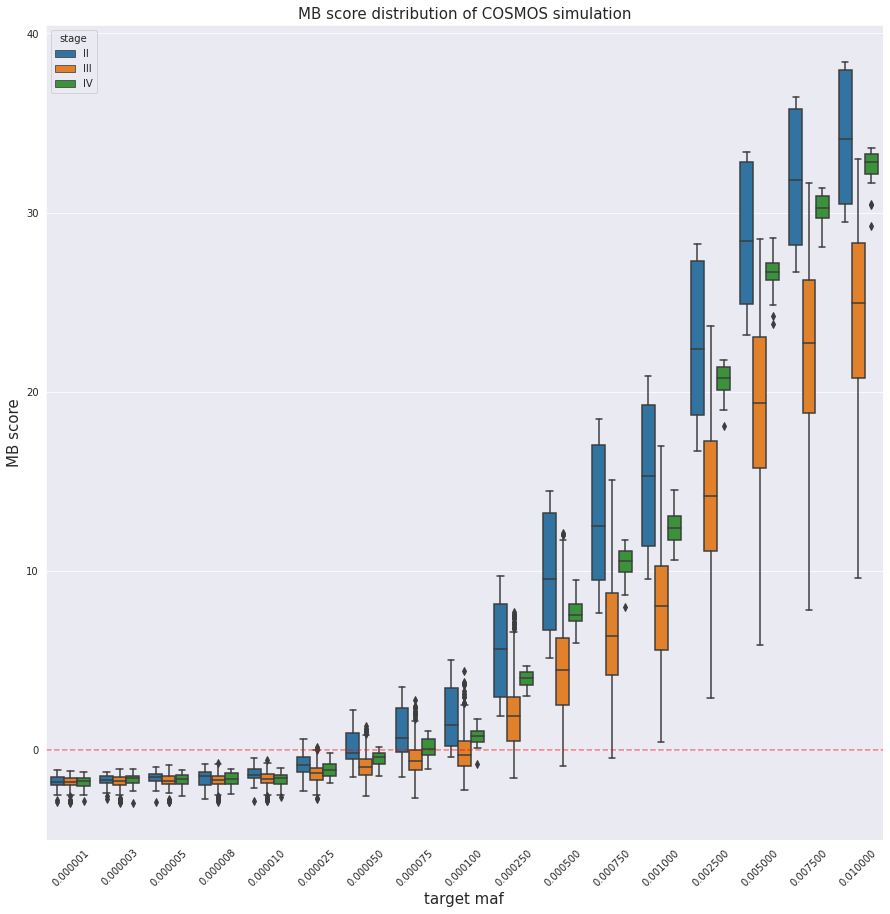

In [100]:
#data visulization for LR score (MB model)
df_cosmos_mb = pd.read_table(f"{work_dir}/COSMOS_CV_MB_score.tsv")
df_cosmos_mb["mb_score"] = df_cosmos_mb["mb_score"] + 20.2


fig,ax0=plt.subplots(nrows=1, figsize=(15,15))
sns.set_style('darkgrid')
# sns.boxplot(x = "target_maf", y = "mb_score", data = df_cosmos_mb, color="skyblue")
sns.boxplot(x="target_maf", y="mb_score", hue="stage", data=df_cosmos_mb)
ax0.axhline(0, color='red', linestyle='--', alpha=0.5)
# plt.xlabel('target maf')
# plt.ylabel('MB score')
plt.title('MB score distribution of COSMOS simulation', fontsize=15)
# plt.legend(loc='best')
# plt.rc('legend',fontsize=20)
plt.xticks(rotation=45)
#plt.yticks(fontsize=25)
#plt.xticks(fontsize=25)
# ax0.set_xlim([0, 1])
# ax0.set_ylim([0, 1])
ax0.set_xlabel('target maf', fontsize=15)
ax0.set_ylabel('MB score',fontsize=15)

# Format x-ticks labels
formatted_ticks = ['{:.6f}'.format(tick) for tick in df_cosmos_mb["target_maf"].unique()]
ax0.set_xticklabels(formatted_ticks)

plt.show()

### Deep dive for patient samples whose LoD is higher than 0.00001

In [41]:
#based on MB model AV LoD which is 0.0001. It worth to check the negative samples at/above that target_maf 
#at each target_maf, each sample we have 24 simulated datepoints and totally 13 x 24 at each target_maf. 
#we set the empirical call rate cutoff at 95%. So for each specific patient at each target_maf, if its # neg datapoints > 5% x #total datapoints at this target_maf (24). It means the LoD of this sample will at least higher than this target_maf. 

def check_neg_patient_target_maf(target_maf, df_cosmos_mb, df_tvf_filtered):
    '''
    arguments: 
        target_maf: target_maf 
        df_cosmos_mb: df with mb score and sample ID
        df_tvf_filtered: df with tvf variants information and sample ID
        
    output:
        return a df of samples whose LoD is higher than the target_maf and their tvf info
        
    '''
    
    #find all patient samples who has negative mb score at this target_maf
    df_cosmos_neg = df_cosmos_mb[(df_cosmos_mb["target_maf"] == target_maf) & (df_cosmos_mb["mb_score"] < 0)]
    print("# neg mb score datapoints of each patient sample at target_maf {} is \n{}".format(target_maf, df_cosmos_neg.run_sample_id.value_counts()))
    
    #filter on patients whose LoD is larger than this target_maf (based on empirical method)
    counts = df_cosmos_neg.groupby('run_sample_id').size()
    filtered_ids_neg = counts[counts > 24 * 0.05].index.tolist() #there are 24 datapoints (cuz total 24 cancer-free samples) for each patient sample at each target_maf

    #summarize the tvf information of those patients
    df_tvf_neg = df_tvf_filtered[df_tvf_filtered.sample_id.isin(filtered_ids_neg)]
    print("# samples whose LoD > target_maf {} is {}".format(target_maf, df_tvf_neg.shape[0]))
    
    #return the summary table and adding stage information
    df_tvf_neg_simple = df_tvf_neg.loc[:, ['sample_id', 'chrom', 'pos', 'mut_nt', 'maf', 'gene', 'type', 'gene_cn', 'median_mapq']]
    df_cosmos_neg.rename(columns={'run_sample_id': 'sample_id'}, inplace=True)
    df_cosmos_neg = df_cosmos_neg.drop_duplicates(subset=['sample_id'])
    df_tvf_neg_simple = df_tvf_neg_simple.merge(df_cosmos_neg[["sample_id", "stage"]], on = "sample_id", how = "left")

    # print(df_tvf_neg)
    print(df_tvf_neg_simple)
    print("\n") 
    # df_tvf_neg_simple.head(100)

    return df_tvf_neg_simple

check_neg_patient_target_maf(0.0001, df_cosmos_mb, df_tvf_filtered)
check_neg_patient_target_maf(0.00025, df_cosmos_mb, df_tvf_filtered)
check_neg_patient_target_maf(0.0005, df_cosmos_mb, df_tvf_filtered)


# neg mb score datapoints of each patient sample at target_maf 0.0001 is 
A034447610    24
A039781709    24
A032938309    24
A034648610    22
A032992910    16
A030871210    14
A025851610     8
A033995510     7
A025425210     5
A026969210     1
Name: run_sample_id, dtype: int64
# samples whose LoD > target_maf 0.0001 is 9
    sample_id  chrom        pos                         mut_nt       maf gene  \
0  A032992910      5  112173483                           CA>C  0.014963  APC   
1  A034447610      5  112175337  ACAAAGCTGTTGAATTTTCTTCAGGAG>A  0.038396  APC   
2  A033995510      5  112175337  ACAAAGCTGTTGAATTTTCTTCAGGAG>A  0.013652  APC   
3  A034648610      5  112173483                           CA>C  0.033423  APC   
4  A030871210      5  112175337  ACAAAGCTGTTGAATTTTCTTCAGGAG>A  0.011673  APC   
5  A025851610      5  112175532                           TA>T  0.033702  APC   
6  A025425210      5  112128191                            C>T  0.018730  APC   
7  A032938309      5  1121757

,sample_id,chrom,pos,mut_nt,maf,gene,type,gene_cn,median_mapq,stage
0,A039781709,5,112155042,GT>G,0.02042,APC,indel,2.085354,60.0,III


### LoD data visulization

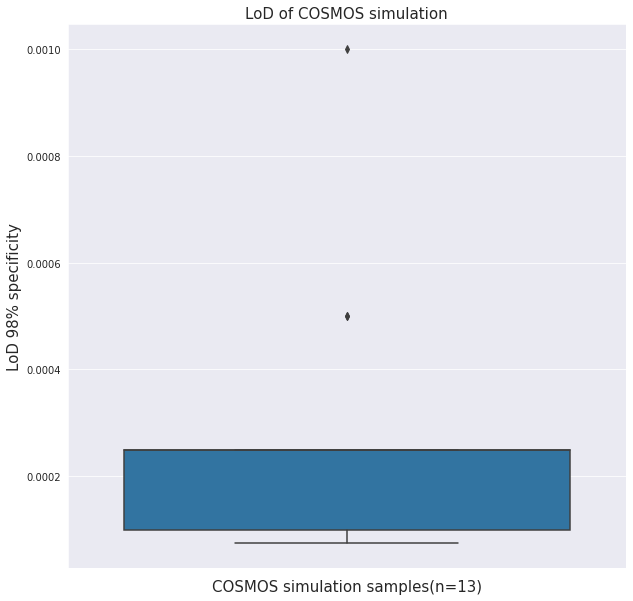

The LoD on COSMOS MB rerun samples had a median value of 0.000250 with a standard deviation of 0.000253. The 95% confidence interval for the median is between -0.000301 and 0.000801. Based on our analysis, we identified 3 outliers in the dataset and they are ['A034447610' 'A039781709' 'A032938309'] with corresponding values: [0.0005 0.001  0.0005].




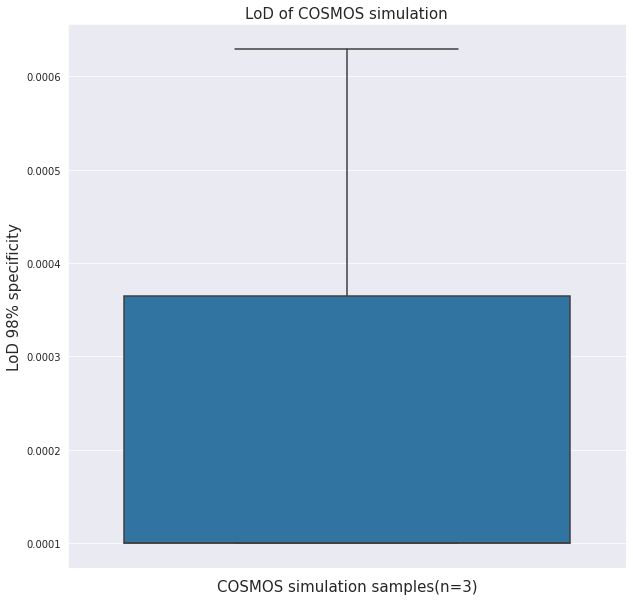

The LoD on COSMOS MB rerun samples had a median value of 0.000100 with a standard deviation of 0.000305. The 95% confidence interval for the median is between -0.001214 and 0.001415. Based on our analysis, we identified 0 outliers in the dataset and they are [] with corresponding values: [].




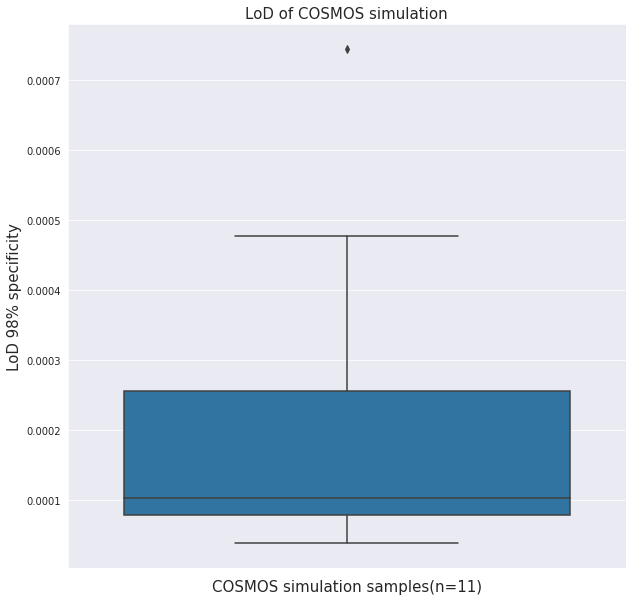

The LoD on COSMOS MB rerun samples had a median value of 0.000102 with a standard deviation of 0.000221. The 95% confidence interval for the median is between -0.000391 and 0.000595. Based on our analysis, we identified 1 outliers in the dataset and they are ['A039781709'] with corresponding values: [0.00074516].




In [26]:
#data visualization for LoD with 98% specificity of 13 COSMOS simulated samples (17 simulations for each sample)

def boxplot_LoD_all(filename):
    #read input
    df_cosmos_lod = pd.read_table(f"{work_dir}/{filename}")
    df_cosmos_lod = df_cosmos_lod.dropna(subset=['LoD'])
    
    #plot the data
    fig,ax0=plt.subplots(nrows=1, figsize=(10,10))
    sns.set_style('darkgrid')
    sns.boxplot(y=df_cosmos_lod['LoD'])

    plt.title('LoD of COSMOS simulation', fontsize=15)
    ax0.set_xlabel(f"COSMOS simulation samples(n={df_cosmos_lod.shape[0]})", fontsize=15)
    ax0.set_ylabel('LoD 98% specificity',fontsize=15)
    plt.show()
    
    # Calculating statistics
    median = df_cosmos_lod['LoD'].median()
    std_dev = df_cosmos_lod['LoD'].std()
    confidence_level = 0.95
    degrees_freedom = df_cosmos_lod['LoD'].count() - 1
    confidence_interval = stats.t.interval(confidence_level, degrees_freedom, median, std_dev)

    # Filtering outliers
    Q1 = df_cosmos_lod['LoD'].quantile(0.25)
    Q3 = df_cosmos_lod['LoD'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_cosmos_lod[(df_cosmos_lod['LoD'] < (Q1 - 1.5 * IQR)) | (df_cosmos_lod['LoD'] > (Q3 + 1.5 * IQR))]

    # Generating statement
    statement = (f"The LoD on COSMOS MB rerun samples had a median value of {median:.6f} with a standard deviation of {std_dev:.6f}. "
                 f"The 95% confidence interval for the median is between {confidence_interval[0]:.6f} and {confidence_interval[1]:.6f}. "
                 f"Based on our analysis, we identified {outliers.shape[0]} outliers in the dataset and they are {outliers['run_sample_id'].values} with corresponding values: {outliers['LoD'].values}." + "\n")
    print(statement + "\n")

boxplot_LoD_all("COSMOS_CV_Empirical_LoD.tsv")
boxplot_LoD_all("COSMOS_CV_LR_anchor_LoD.tsv")
boxplot_LoD_all("COSMOS_CV_probit_LoD.tsv")

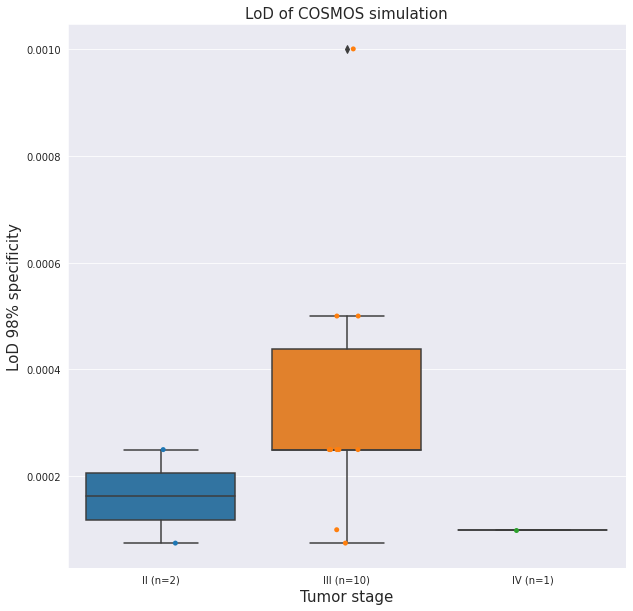

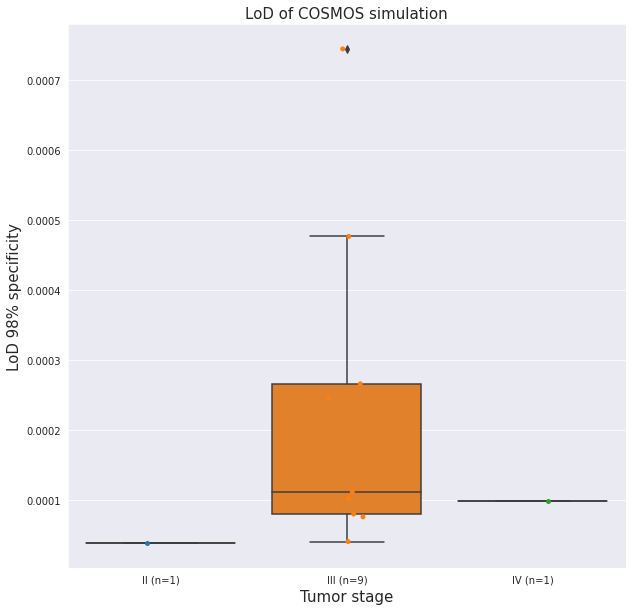

In [28]:
#plot LoD by each stage

def boxplot_LoD_stage(filename):
    #read input
    df_cosmos_lod = pd.read_table(f"{work_dir}/{filename}")
    df_cosmos_lod = df_cosmos_lod.dropna(subset=['LoD'])
    
    
    fig, ax0 = plt.subplots(nrows=1, figsize=(10, 10))
    sns.set_style('darkgrid')

    # Specify the desired order
    desired_order = ["II", "III", "IV"]

    # Plotting the boxplot and stripplot with the specified order
    sns.boxplot(data=df_cosmos_lod, x="stage", y="LoD", ax=ax0, order=desired_order)
    sns.stripplot(data=df_cosmos_lod, x="stage", y="LoD", jitter=True, size=5, ax=ax0, order=desired_order)

    # Getting counts for each category in the "stage" column
    stage_counts = df_cosmos_lod['stage'].value_counts()

    # Creating custom labels based on the desired order
    labels = [f"{stage} (n={stage_counts[stage]})" for stage in desired_order]

    # Setting the custom labels
    ax0.set_xticks(range(len(labels)))
    ax0.set_xticklabels(labels)

    # Setting other plot properties
    plt.title('LoD of COSMOS simulation', fontsize=15)
    ax0.set_xlabel('Tumor stage', fontsize=15)
    ax0.set_ylabel('LoD 98% specificity', fontsize=15)
    plt.show()
    

boxplot_LoD_stage("COSMOS_CV_Empirical_LoD.tsv")
# boxplot_LoD_stage("COSMOS_CV_LR_anchor_LoD.tsv")
boxplot_LoD_stage("COSMOS_CV_probit_LoD.tsv")

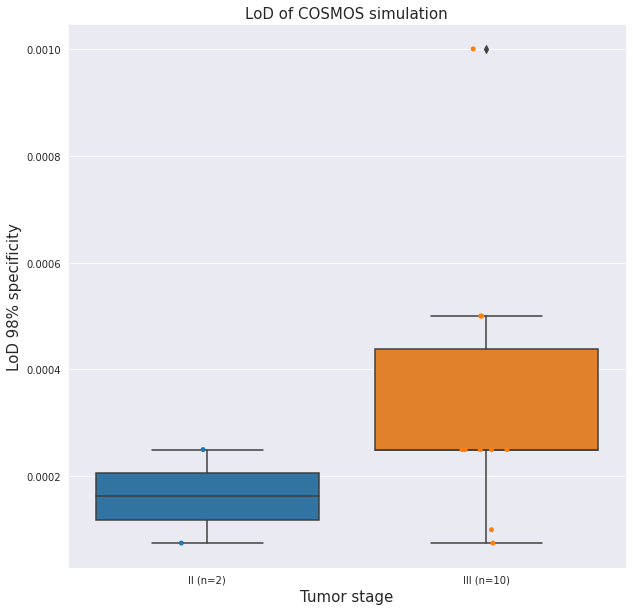

In [98]:
df_cosmos_lod = pd.read_table(f"{work_dir}/COSMOS_CV_Empirical_LoD.tsv")
df_cosmos_lod = df_cosmos_lod[df_cosmos_lod["stage"] != "IV"]
df_cosmos_lod = df_cosmos_lod.dropna(subset=['LoD'])

fig, ax0 = plt.subplots(nrows=1, figsize=(10, 10))
sns.set_style('darkgrid')

# Specify the desired order
desired_order = ["II", "III"]

# Plotting the boxplot and stripplot with the specified order
sns.boxplot(data=df_cosmos_lod, x="stage", y="LoD", ax=ax0, order=desired_order)
sns.stripplot(data=df_cosmos_lod, x="stage", y="LoD", jitter=True, size=5, ax=ax0, order=desired_order)

# Getting counts for each category in the "stage" column
stage_counts = df_cosmos_lod['stage'].value_counts()

# Creating custom labels based on the desired order
labels = [f"{stage} (n={stage_counts[stage]})" for stage in desired_order]

# Setting the custom labels
ax0.set_xticks(range(len(labels)))
ax0.set_xticklabels(labels)

# Setting other plot properties
plt.title('LoD of COSMOS simulation', fontsize=15)
ax0.set_xlabel('Tumor stage', fontsize=15)
ax0.set_ylabel('LoD 98% specificity', fontsize=15)
plt.show()

In [48]:
# df_cosmos_lod = pd.read_table(f"{work_dir}/MRD_AV_probit_test1.tsv")

# fig, ax = plt.subplots(1, 2, figsize=(12, 10))
# sns.set_style('darkgrid')

# # Boxplot on the first subplot
# sns.boxplot(y=df_cosmos_lod['LoD'], ax=ax[0], color='lightblue')
# ax[0].set_title('Boxplot of LoD')
# ax[0].set_ylabel('LoD 98% specificity')
# ax[0].set_xlabel('COSMOS simulation samples')

# # Stripplot on the second subplot
# sns.stripplot(y=df_cosmos_lod['LoD'], ax=ax[1], color='black', jitter=True, size=5)
# ax[1].set_title('Stripplot of LoD')
# ax[1].set_ylabel('LoD 98% specificity')
# ax[1].set_xlabel('COSMOS simulation samples')

# plt.tight_layout()
# plt.show()


In [178]:
# #based on MB model AV LoD which is 0.0001. It worth to check the negative samples at/above that target_maf 
# #at each target_maf, each sample we have 24 simulated datepoints and totally 13 x 24 at each target_maf. 
# #we set the empirical call rate cutoff at 95%. So for each specific patient at each target_maf, if its # neg datapoints > 5% x #total datapoints at this target_maf (24). It means the LoD of this sample will at least higher than this target_maf. 

# #at target_maf 0.0001
# df_cosmos_00001_neg = df_cosmos_mb[(df_cosmos_mb["target_maf"] == 0.0001) & (df_cosmos_mb["mb_score"] < 0)]
# print("# neg mb score datapoints of each patient sample at target_maf 0.0001 is " + "\n" + str(df_cosmos_00001_neg.run_sample_id.value_counts()) + "\n") 
# counts = df_cosmos_00001_neg.groupby('run_sample_id').size()
# filtered_ids_00001_neg = counts[counts > 24 * 0.05].index.tolist() #there are 24 datapoints (cuz total 24 cancer-free samples) for each patient sample at each target_maf
# df_tvf_00001_neg = df_tvf_filtered[df_tvf_filtered.sample_id.isin(filtered_ids_00001_neg)]
# print("# samples whose LoD > target_maf 0.0001 is " + str(df_tvf_00001_neg.shape[0]) + "\n") 
# df_tvf_00001_neg_simple = df_tvf_00001_neg.loc[:,['sample_id', 'chrom', 'pos', 'mut_nt', 'mut_aa', 'maf', 'mut_cnt', 'gene']]
# print(df_tvf_00001_neg_simple)

# #at target_maf 0.00025
# df_cosmos_000025_neg = df_cosmos_mb[(df_cosmos_mb["target_maf"] == 0.00025) & (df_cosmos_mb["mb_score"] < 0)]
# print("# neg mb score datapoints of each patient sample at target_maf 0.00025 is " + "\n" + str(df_cosmos_000025_neg.run_sample_id.value_counts()) + "\n") 
# counts = df_cosmos_000025_neg.groupby('run_sample_id').size()
# filtered_ids_000025_neg = counts[counts > 24 * 0.05].index.tolist() #there are 24 datapoints (cuz total 24 cancer-free samples) for each patient sample at each target_maf
# df_tvf_000025_neg = df_tvf_filtered[df_tvf_filtered.sample_id.isin(filtered_ids_000025_neg)]
# print("# samples whose LoD > target_maf 0.00025 is " + str(df_tvf_000025_neg.shape[0]) + "\n") 
# df_tvf_000025_neg_simple = df_tvf_000025_neg.loc[:,['sample_id', 'chrom', 'pos', 'mut_nt', 'mut_aa', 'maf', 'mut_cnt', 'gene']]
# print(df_tvf_000025_neg_simple)

# #at target_maf 0.0005
# df_cosmos_00005_neg = df_cosmos_mb[(df_cosmos_mb["target_maf"] == 0.0005) & (df_cosmos_mb["mb_score"] < 0)]
# print("# neg mb score datapoints of each patient sample at target_maf 0.0005 is " + "\n" + str(df_cosmos_00005_neg.run_sample_id.value_counts()) + "\n") 
# counts = df_cosmos_00005_neg.groupby('run_sample_id').size()
# filtered_ids_00005_neg = counts[counts > 24 * 0.05].index.tolist() #there are 24 datapoints (cuz total 24 cancer-free samples) for each patient sample at each target_maf
# df_tvf_00005_neg = df_tvf_filtered[df_tvf_filtered.sample_id.isin(filtered_ids_00005_neg)]
# print("# samples whose LoD > target_maf 0.0005 is " + str(df_tvf_00005_neg.shape[0]) + "\n")
# df_tvf_00005_neg_simple = df_tvf_00005_neg.loc[:,['sample_id', 'chrom', 'pos', 'mut_nt', 'mut_aa', 'maf', 'mut_cnt', 'gene']]
# print(df_tvf_00005_neg_simple)